In [58]:
import os
import re
import random
from glob import glob

import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.io import loadmat
from matplotlib.colors import TwoSlopeNorm
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [49]:
def load_datafolder_to_get_tag_paths(zebfolderpath, 
                  pattern='z.*f\d+', 
                  rmfname="README_LICENSE.rtf",
                  sortkey=None, 
                  reverse=False,
        ):
    tag = re.findall(r'{}'.format(pattern), zebfolderpath)[0]

    files = os.listdir(zebfolderpath)
    # sort by sortkey if exits
    if sortkey:
        files.sort(key=sortkey, reverse=reverse)
    else: 
        files.sort(reverse=reverse)

    # rm unwanted files in dir
    files.remove(rmfname)

    path0, path1 = [zebfolderpath + "/" + fname for fname in files]

    return tag, path0, path1


def read_data(
        path0, 
        path1, 
        num_rois, 
        d1key='data',
        dholderkey='CellResp', 
        cellpositions_var="CellXYZ",
        eliminate_cells_key='IX_inval_anat',
        scells=True,
    ):
    dholder = h5py.File(path0, "r")
    d0 = dholder[dholderkey][:]  # responses
    d1 = loadmat(path1, simplify_cells=scells)

    eliminated_rois = d1[d1key][eliminate_cells_key] # rename keys later
    all_rois = d1[d1key][cellpositions_var] # roi positions x, y, z

    used_rois_coor = np.array(
        [row for j, row in enumerate(all_rois) if j not in list(eliminated_rois)]
    )

    x, y, z = used_rois_coor[:num_rois, :].T

    return x, y, z, d0


def get_n_nearest_nbrs(ds, roi_idx, n=10):
    nn_idx = ds[roi_idx,].argsort()[1 : n + 1]

    return nn_idx


def get_n_nearest_nbrs_dist(ds, roi_idx, n=10):
    nn_dists = ds[roi_idx][ds[roi_idx,].argsort()][1 : n + 1]

    return nn_dists
 
def compute_cell_distances(x, y, metric='euclidean'):
     ds = squareform(pdist(np.array([x, y]).T, metric=metric))
 
     return ds
 

def get_n_random_nbrs(roi_idx, len0=100, n=10):

    all_idx = list(range(len0))
    all_idx.remove(roi_idx)
    rn_idx = random.sample(all_idx, n)

    return rn_idx


def get_roi_indices_region(xall=None, yall=None, x0=None, y0=None, x1=None, y1=None, wherespecify=None):
    '''returns roi indices for given  square region where (x0 < x < x1), (y0 < y < y1)'''
    ''' possibly extend of circular region'''
    if wherespecify is not None:
        return np.where(wherespecify)[0]
    
    return np.where(((xall > x0) & (xall < x1)) & ((yall > y0) & (yall < y1)))[0]
    

def get_roi_positions(inxy):
    '''returns the (x, y) for rois given the indices'''
    x, y = x[inxy], y[inxy] 
    return x, y

def compute_n_nearest_nbrs_corr_for_roi(
        roi_idx, 
        d0, 
        dS,
        neigh_pop, 
    ):
    """ return for correlations given roi_index, 
        of length n  for nearest neighbours 
        """

    # create arrays to store values
    nncorrs_per_roi = np.empty(neigh_pop, dtype=float) 

    # get signal for roi_index
    roi_response = d0[:, roi_idx]

    # get n random and nearest neighbours
    nn_idx = get_n_nearest_nbrs(dS, roi_idx, n=neigh_pop)

    # get nearest and random neighbours responses
    nnrois_responses = d0[:, nn_idx]

    # compute nn and rn correlations 
    for j in range(neigh_pop):
        nn_corr = np.corrcoef(roi_response, nnrois_responses[:, j])[0, 1]
        nncorrs_per_roi[j] = nn_corr

    return nncorrs_per_roi


def compute_n_random_nbrs_corr_for_roi(
        roi_idx, 
        d0, 
        neigh_pop, 
        num_rois,
    ):
    """ return for given roi_index, two arrays of correlations 
        of length n;one for nearest neighbours, 
        another for random neighbours """

    # create arrays to store values
    rncorrs_per_roi = np.empty(neigh_pop, dtype=float) 

    # get signal for roi_index
    roi_response = d0[:, roi_idx]

    # get n random and nearest neighbours
    rn_idx = get_n_random_nbrs(
                               roi_idx, 
                               len0=num_rois,  
                               n=neigh_pop,
            ) 

    # get nearest and random neighbours responses
    rnrois_responses = d0[:, rn_idx]

    # compute nn and rn correlations 
    for j in range(neigh_pop):
        rn_corr = np.corrcoef(roi_response, rnrois_responses[:, j])[0, 1]
        rncorrs_per_roi[j] = rn_corr

    return  rncorrs_per_roi


# Compute the radial cscale of data, to get a sense of the size of the neighbourhoods
def compute_radial_scale_for_n_nbrs(ds, num_rois, neigh_pop):
    """Return mean radial scale for number of rois used."""
    max_dists = np.empty(num_rois, dtype=float)
    for roi_idx in range(num_rois):
        dists = get_n_nearest_nbrs_dist(ds=ds, roi_idx=roi_idx, n=neigh_pop)
        max_dists[roi_idx] =  dists.max()

    radial_scale = max_dists.sum()/ num_rois
    
    return radial_scale


def abib_cdf(r, xlabel, r_min=-np.inf, **kwargs):

    r_kept = r[r > r_min]
    print(f"Dropped {len(r) - len(r_kept)} values less than {r_min=}")
    x = sorted(r_kept)
    y = np.arange(1, len(r_kept) + 1) / (len(r_kept))
    plt.plot(x, y, **kwargs)
    if xlabel is None:
        plt.xlabel('Samples', fontsize=20)
    else:
        plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Cumulative Probability", fontsize=20)

    return r_kept


def get_roi_index_from_position(x, y, x0, y0):
    return np.intersect1d((np.nonzero(x == x0)), (np.nonzero(y== y0)))[0]


def sort_rois_in_plot_layout(roi, nn_arr, rn_arr):
    n = 2 + 2 * len(rn_arr)
    ls0 = [roi]*n
    for i, (nn, rn) in enumerate(zip(nn_arr, rn_arr)):
        ls0[2*i+2] = nn
        ls0[2*i+3] = rn
    return ls0


def render_signal_correlations_for_roi(d0, roi, nn_arr, rn_arr, roi_roc, nn_corr, rn_corr):

    """ Plots the signals or near and random neighs for visual comparisions"""
    # sort rois for plot layout
    ls_roi_idx  = sort_rois_in_plot_layout(roi, nn_arr, rn_arr)

    # compute nrows for plot
    nrows = int(len(ls_roi_idx)/2)
    ls0_iter = iter(ls_roi_idx)
    
    # sort correlations
    ls_roi_corr = sort_rois_in_plot_layout(roi_roc, nn_corr, rn_corr)
    ls_roi_corr_iter = iter(ls_roi_corr)

    fig, axs = plt.subplots(ncols=2, 
                           nrows=nrows, 
                           figsize=(15, 4),
                           layout="constrained",
                )
    # for each Axes, add an artist, in this case a nice label in the middle...
    for row in range(4):
        for col in range(2):
            idx = next(ls0_iter) # get index of next plot
            cori = round(next(ls_roi_corr_iter), 3)

            if (row > 0) & (col == 1):
                # plotting random neighbours
                axs[row, col].plot(d0[:, idx][80:1880], linewidth=0.5, label=f'{idx}:{cori}',  color='orange' )

            elif row == 0:
                # plotting main signal
                axs[row, col].plot(d0[:, idx][80:1880],  linewidth=0.5, color= 'blue', label=f'{idx}:{cori}')

            else:
                # plotting near neighbours
                axs[row, col].plot(d0[:, idx][80:1880],  linewidth=0.5, color='red', label=f'{idx}:{cori}')
            axs[row, col].set_facecolor('#eafff5')
            axs[row, col].text(-0.5, -0.15, s=f'{idx}:{cori}', color='red')
            axs[row, col].legend(handlelength=0, fontsize='large', loc='lower left', labelcolor='white', frameon=False)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            axs[row, col].margins(x=0)
            axs[row, col].annotate(f'', (0.5, 0.5),
                                transform=axs[row, col].transAxes,
                                ha='center', va='center', fontsize=18,
                                color='darkgrey')
                

    axs[3, 0].set_xticks([0, 1800])
    axs[3, 1].set_xticks([0, 1800])
    axs[0, 0].set_title('Main ROI, ROI IDX : ROC', loc='left', fontsize='medium') 

    #axs[1, 0].set_title('Nearest Neighbours', loc='left', fontsize='medium') 
    #axs[1, 1].set_title('Random Neighbours', loc='right', fontsize='medium') 
    fig.suptitle("Correlations Sanity Check: Rendering correlations for given ROI")
    plt.show()

    

    return None
    

def compute_roc(nn_corr, rn_corr):

    roc = (nn_corr / (2 +  rn_corr)) 

    return roc


# need to check this function.
def compute_radial_scale_for_n_nbrs(ds, num_rois, neigh_pop):
    """Return mean radial scale for number of rois used."""
    max_dists = np.empty(num_rois, dtype=float)
    for roi_idx in range(num_rois):
        dists = get_n_nearest_nbrs_dist(ds=ds, roi_idx=roi_idx, n=neigh_pop)
        max_dists[roi_idx] =  dists.max()

    radial_scale = max_dists.sum()/ num_rois
    
    return radial_scale, max_dists

# set params 

In [5]:
num_rois = 2000
seed = None
nnpop = 100
fileDir = "/Users/duuta/ppp/data/zebf00/"
sdir = None
rnpop = 100 

# get data and vars using defined params 

In [6]:
tag, path0, path1 = load_datafolder_to_get_tag_paths(fileDir)

# read file paths
x, y, _, d0 = read_data(path0, path1, num_rois=num_rois, scells=True)
print("can read the file path... yes.... frantically reading files.....")

# compute distances between rois
dS = compute_cell_distances(x, y)

print("franticall computing distances......")

can read the file path... yes.... frantically reading files.....
franticall computing distances......


In [11]:
def compute_render_ratio_corr0(
    x, y,
    d0, dS, 
    num_rois=30000, 
    nnpop=nnpop, rnpop=rnpop, 
    seed=None, 
    tag=None, 
    sdir=None, 
    figsize=(10, 10), 
    edgecolor='white', 
    marker_size=10, 
    radial_scale=10,
    circle_patch=False,
    tar0_idx=None,
    high_target_rois_list = None, 
):
    nn_corrs = np.empty(num_rois, dtype=float)
    rn_corrs = np.empty(num_rois, dtype=float)

    # get rois in given region
    target_rois_list =  get_roi_indices_region(x, y, x0=1400, x1=1600, y0=400, y1=500)

    # compute roc for rois of given index 
    ## create function to compute roi for given roi
    for roi_idx in range(
        num_rois
    ):  # need to account for cases where the pass a list of roi indices
        random.seed(seed)
        nncorrs_per_roi = compute_n_nearest_nbrs_corr_for_roi(
             roi_idx=roi_idx,
             d0=d0,
             dS=dS,
             neigh_pop=10,
        )
        rncorrs_per_roi = compute_n_random_nbrs_corr_for_roi(
            roi_idx=roi_idx,
            d0=d0,
            neigh_pop=10,
            num_rois=num_rois, 
        )

        nn_corrs[roi_idx] = nncorrs_per_roi.mean()
        rn_corrs[roi_idx] = rncorrs_per_roi.mean()

    # compute roc for data
    roc = ( nn_corrs  ) / (rn_corrs + 2)
    print(roc)

    # get high correlation target & positions
    tar0_idx_high = high_target_rois_list[0]

    # get sample targets & target positions
    tar00_idx = target_rois_list[1]
    tar01_idx = target_rois_list[2]
    tar02_idx = target_rois_list[3]
    
    tar0_x, tar0_y = x[tar0_idx], y[tar0_idx]
    tar00_x , tar00_y = x[tar00_idx], y[tar00_idx]
    tar01_x , tar01_y= x[tar01_idx], y[tar01_idx]

    # get poistion of high corrs
    tar0_high_x, tar0_high_y = x[tar0_idx_high], y[tar0_idx_high] 


    # target rois neighbours for low regions
    tar00_nn_corr = compute_n_nearest_nbrs_corr_for_roi(
         roi_idx=tar00_idx,
         d0=d0,
         dS=dS,
         neigh_pop=2,
    )

    tar00_nn_idx = get_n_nearest_nbrs(
        roi_idx=tar00_idx,
        ds=dS,
        n=2,
    )

    # target rois neighbours for high regions
    tar0_nn_corr_high = compute_n_nearest_nbrs_corr_for_roi(
        roi_idx = tar0_idx_high,
        d0=d0,
        dS =dS,
        neigh_pop=2
    )

    tar0_nn_idx_high = get_n_nearest_nbrs(
            roi_idx=tar0_idx_high,
            ds=dS,
            n=2,
        )
   
    tar0_high_x, tar0_high_y = x[tar0_idx_high], y[tar0_idx_high]
    tar0_high_nn0_x, tar0_high_nn0_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]
    tar0_high_nn1_x, tar0_high_nn1_y = x[tar0_nn_idx_high[0]], y[tar0_nn_idx_high[0]]

    # get random neighbours 
    

    fig0 = plt.figure(figsize=figsize)
    print(roc.mean(), roc.min(), roc.max())
    custom_norm = TwoSlopeNorm(vcenter=0.10, vmin=-0.03, vmax=0.50)

    ax = plt.axes()
        
    ps0=plt.scatter(
            x[:num_rois],
            y[:num_rois],
            marker=".",
            norm=custom_norm,
            cmap="rainbow",
            s=marker_size,
            c=roc,
    )

################  ###  # get current axis and inset new axes for  high correlations 
#    ax0=plt.gca().inset_axes((0.01, 0.8, 0.5, 0.1), facecolor='white')
#    offset = 0
#    for roi_idx in high_target_rois_list[:3]:
#        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
#             linewidth=0.5, 
#        )
#        offset = np.std(d0[:, roi_idx]) 
#
#    ax0.legend([f'Target Neuron {tar0_idx_high} : roc={round(roc[tar0_idx_high], 3)}', 
#                f'NN0:{tar0_nn_idx_high[0]} : cor={round(tar0_nn_corr_high[0], 3)}', 
#                f'NN1:{tar0_nn_idx_high[1]} : cor={round(tar0_nn_corr_high[1], 3)}'], 
#                labelcolor='black')
#    ax0.set_yticks([])
#    ax0.set_xticks([])
#
#    # specify color of arrows by color of signal using facecolor
#    plt.gca().annotate(f"ROI:{tar0_idx_high}",
#                       color ='white',
#                       xy = (1050, 950), 
#                       xytext=(tar0_high_x, tar0_high_y),
#                       arrowprops=dict(arrowstyle="fancy",
#                                        facecolor='blue',
#                                        patchB=ax0,
#                                        shrinkB=5,
#                                        connectionstyle="arc3,rad=0.3",
#                                    ),
#                    ) 
#    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[0]}",
#                        color = "white",
#                        xy = (1050, 950), # need to set this as the top right corner of inset plot 
#                        xytext=(tar0_high_nn0_x, tar0_high_nn0_y),
#                        arrowprops=dict(arrowstyle="fancy",
#                                       facecolor="orange",
#                                       patchB=ax0,
#                                       shrinkB=5,
#                                       connectionstyle="arc3,rad=0.3",
#                                    ),
#                    )
#    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[1]}",
#                       color='white',
#                       xy = (1050, 950),
#                       xytext=(tar0_high_nn1_x, tar0_high_nn1_y),
#                       arrowprops=dict(arrowstyle="fancy",
#                                       facecolor="green",
#                                       patchB=ax0,
#                                       shrinkB=5,
#                                       connectionstyle="arc3,rad=0.3",
#                                    ),
#                    )
########   # get current axis and inset new axes for low corrs 
#    ax0=plt.gca().inset_axes((0.01, 0.2, 0.5, 0.1), facecolor='white')
#    offset = 0
#    for roi_idx in target_rois_list[:3]:
#        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
#             linewidth=0.5, 
#        )
#        offset = np.std(d0[:, roi_idx]) 
#
#    ax0.legend([f'Target Neuron {tar00_idx} : roc={round(roc[tar00_idx], 3)}', 
#                f'NN0:{tar00_nn_idx[0]} : cor={round(tar00_nn_corr[0], 3)}', 
#                f'NN1:{tar00_nn_idx[1]} : cor={round(tar00_nn_corr[1], 3)}'], 
#                labelcolor='black')
#    ax0.set_yticks([])
#    ax0.set_xticks([])
#
#    # specify color of arrows by color of signal using facecolor
#    plt.gca().annotate(f"ROI:{tar0_idx}",
#                       color ='white',
#                       xy = (1050, 350),
#                       xytext=(tar0_x, tar0_y),
#                       arrowprops=dict(arrowstyle="fancy",
#                                        facecolor='blue',
#                                        patchB=ax0,
#                                        shrinkB=5,
#                                        connectionstyle="arc3,rad=0.3",
#                                    ),
#                    ) 
#    plt.gca().annotate(f"ROI:{tar00_idx}",
#                        color = "white",
#                        xy = (1050, 350), # need to set this as the top right corner of inset plot 
#                        xytext=(tar00_x, tar00_y),
#                        arrowprops=dict(arrowstyle="fancy",
#                                       facecolor="orange",
#                                       patchB=ax0,
#                                       shrinkB=5,
#                                       connectionstyle="arc3,rad=0.3",
#                                    ),
#                    )
#    plt.gca().annotate(f"ROI:{tar01_idx}",
#                       color='white',
#                       xy = (1050, 350),
#                       xytext=(tar01_x, tar01_y),
#                       arrowprops=dict(arrowstyle="fancy",
#                                       facecolor="green",
#                                       patchB=ax0,
#                                       shrinkB=5,
#                                       connectionstyle="arc3,rad=0.3",
#                                    ),
#                    ) 
    # need to come back to this... 
    #nn_dist = find_nearest_nbrs_dist(dS, roi_idx)
    #radius =  max(nn_dist)/num_rois

    if circle_patch:
        plt.gca().add_patch(plt.Circle((200, 50), radius=radial_scale, facecolor='none', edgecolor='white', linewidth=2.5))

    plt.colorbar(ps0, spacing='proportional', shrink=0.5).ax.set_yscale('linear')
    plt.xlabel("ROI X Positions", fontsize=20)
    plt.ylabel("ROI Y Positions", fontsize=20)
    #plt.grid(color='white')
    plt.margins(x=0, y=0)
    plt.title(
        f"{tag}:Raw correlation ratios of near ROIs:{nnpop} to random ROIs:{rnpop} seed:{seed}",
        fontsize=20,
    )
    ax.set_facecolor("black")
    plt.tight_layout()
    if sdir:
        plt.savefig(
            f"{sdir}testing_Rawratiocorrelations_{tag}_ROIs:{num_rois}_NN:{nnpop}_seed:{seed}_RN:{rnpop}.png",
        )
    else:
        plt.grid(color='white')
        plt.show()
        
    plt.close()
    # need to run this for different vmax, vmin, mid=1 (first make a function initerim a class later)

    return roc


In [12]:
radial_scale00= compute_radial_scale_for_n_nbrs(ds=dS, num_rois=num_rois, neigh_pop=nnpop)

In [14]:
radial_scale00
high_target_rois_list  = [898, 1017, 62]

In [11]:
def render_ratio_of_corr(
    x, y,
    d0, dS, 
    num_rois=30000, 
    nnpop=10, rnpop=10, 
    seed=None, 
    tag=None, 
    sdir=None, 
    figsize=(10, 10), 
    edgecolor='white', 
    marker_size=10, 
    radial_scale=10,
    circle_patch=False,
    tar0_idx=None,
    high_target_rois_list = None, 
):
    
    

    fig0 = plt.figure(figsize=figsize)
    custom_norm = TwoSlopeNorm(vcenter=1, vmin=roc.min(), vmax=roc.max())
    ax = plt.axes()
        
    ps0=plt.scatter(
            x[:num_rois],
            y[:num_rois],
            marker=".",
            norm=custom_norm,
            cmap="rainbow",
            s=marker_size,
            c=roc,
    )

################  ###  # get current axis and inset new axes for  high correlations 
    ax0=plt.gca().inset_axes((0.01, 0.8, 0.5, 0.1), facecolor='white')
    offset = 0
    for roi_idx in high_target_rois_list[:3]:
        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
             linewidth=0.5, 
        )
        offset = np.std(d0[:, roi_idx]) 

    ax0.legend([f'Target Neuron {tar0_idx_high} : roc={round(roc[tar0_idx_high], 3)}', 
                f'NN0:{tar0_nn_idx_high[0]} : cor={round(tar0_nn_corr_high[0], 3)}', 
                f'NN1:{tar0_nn_idx_high[1]} : cor={round(tar0_nn_corr_high[1], 3)}'], 
                labelcolor='black')
    ax0.set_yticks([])
    ax0.set_xticks([])

    # specify color of arrows by color of signal using facecolor
    plt.gca().annotate(f"ROI:{tar0_idx_high}",
                       color ='white',
                       xy = (1050, 950), 
                       xytext=(tar0_high_x, tar0_high_y),
                       arrowprops=dict(arrowstyle="fancy",
                                        facecolor='blue',
                                        patchB=ax0,
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[0]}",
                        color = "white",
                        xy = (1050, 950), # need to set this as the top right corner of inset plot 
                        xytext=(tar0_high_nn0_x, tar0_high_nn0_y),
                        arrowprops=dict(arrowstyle="fancy",
                                       facecolor="orange",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
    plt.gca().annotate(f"ROI:{tar0_nn_idx_high[1]}",
                       color='white',
                       xy = (1050, 950),
                       xytext=(tar0_high_nn1_x, tar0_high_nn1_y),
                       arrowprops=dict(arrowstyle="fancy",
                                       facecolor="green",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
#######   # get current axis and inset new axes for low corrs 
    ax0=plt.gca().inset_axes((0.01, 0.2, 0.5, 0.1), facecolor='white')
    offset = 0
    for roi_idx in target_rois_list[:3]:
        ax0.plot(d0[:, roi_idx][80:1880] + offset, 
             linewidth=0.5, 
        )
        offset = np.std(d0[:, roi_idx]) 

    ax0.legend([f'Target Neuron {tar00_idx} : roc={round(roc[tar00_idx], 3)}', 
                f'NN0:{tar00_nn_idx[0]} : cor={round(tar00_nn_corr[0], 3)}', 
                f'NN1:{tar00_nn_idx[1]} : cor={round(tar00_nn_corr[1], 3)}'], 
                labelcolor='black')
    ax0.set_yticks([])
    ax0.set_xticks([])

    # specify color of arrows by color of signal using facecolor
    plt.gca().annotate(f"ROI:{tar0_idx}",
                       color ='white',
                       xy = (1050, 350),
                       xytext=(tar0_x, tar0_y),
                       arrowprops=dict(arrowstyle="fancy",
                                        facecolor='blue',
                                        patchB=ax0,
                                        shrinkB=5,
                                        connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    plt.gca().annotate(f"ROI:{tar00_idx}",
                        color = "white",
                        xy = (1050, 350), # need to set this as the top right corner of inset plot 
                        xytext=(tar00_x, tar00_y),
                        arrowprops=dict(arrowstyle="fancy",
                                       facecolor="orange",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    )
    plt.gca().annotate(f"ROI:{tar01_idx}",
                       color='white',
                       xy = (1050, 350),
                       xytext=(tar01_x, tar01_y),
                       arrowprops=dict(arrowstyle="fancy",
                                       facecolor="green",
                                       patchB=ax0,
                                       shrinkB=5,
                                       connectionstyle="arc3,rad=0.3",
                                    ),
                    ) 
    # need to come back to this... 
    #nn_dist = find_nearest_nbrs_dist(dS, roi_idx)
    #radius =  max(nn_dist)/num_rois

    if circle_patch:
        plt.gca().add_patch(plt.Circle((200, 50), radius=radial_scale, facecolor='none', edgecolor='white', linewidth=2.5))

    plt.colorbar(ps0, spacing='proportional', shrink=0.5).ax.set_yscale('linear')
    plt.xlabel("ROI X Positions", fontsize=20)
    plt.ylabel("ROI Y Positions", fontsize=20)
    #plt.grid(color='white')
    plt.margins(x=0, y=0)
    plt.title(
        f"{tag}:Raw correlation ratios of near ROIs:{nnpop} to random ROIs:{rnpop} seed:{seed}",
        fontsize=20,
    )
    ax.set_facecolor("black")
    plt.tight_layout()
    if sdir:
        plt.savefig(
            f"{sdir}testing_Rawratiocorrelations_{tag}_ROIs:{num_rois}_NN:{nnpop}_seed:{seed}_RN:{rnpop}.png",
        )
    else:
        plt.grid(color='white')
        plt.show()
        
    plt.close()
    # need to run this for different vmax, vmin, mid=1 (first make a function initerim a class later)


# compute ratio of correlations

[0.02399272 0.01874298 0.00228664 ... 0.21329598 0.32489258 0.27177659]
0.15339229872198218 -0.013380027423150084 0.49510658138565306


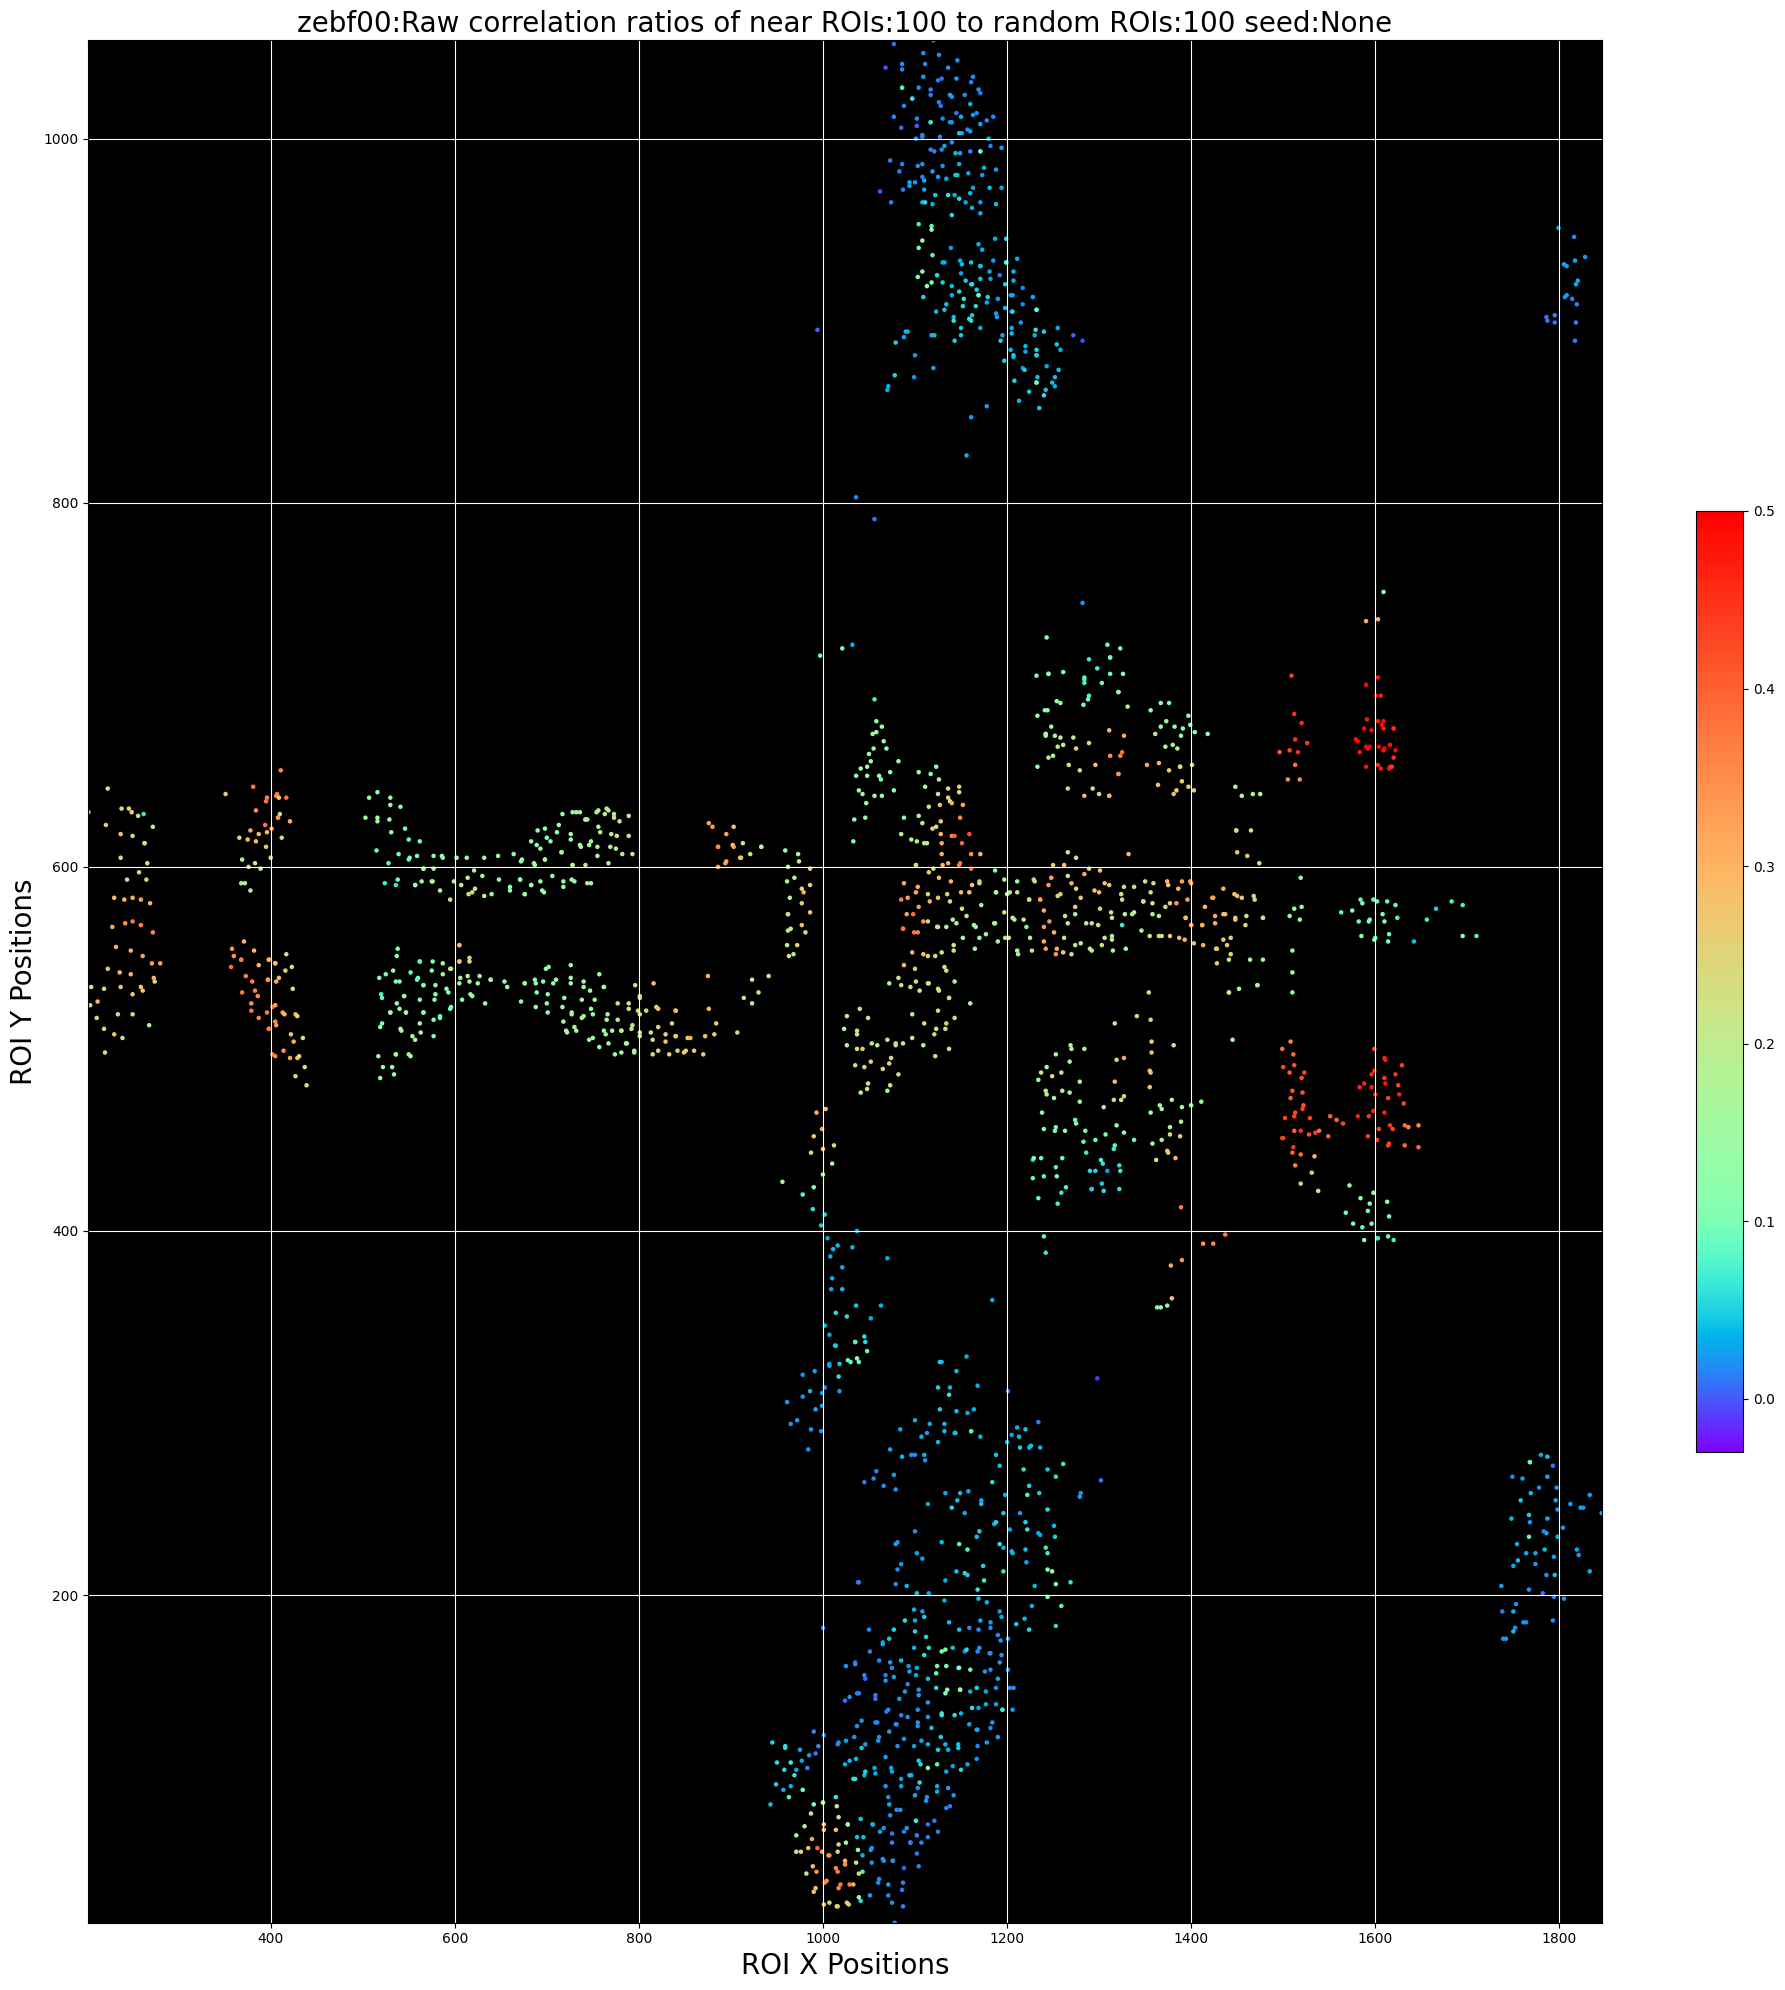

In [15]:
# compute correlation ratio and render plot
abib_correlations = compute_render_ratio_corr0(
    x,
    y,
    d0=d0,
    dS=dS,
    num_rois=num_rois,
    nnpop=nnpop,
    rnpop=rnpop,
    seed=seed,
    tag=tag,
    sdir=sdir,
    radial_scale=None,
    figsize=(20, 20),
    tar0_idx=399,
    marker_size=20,
    circle_patch=False,
    high_target_rois_list=high_target_rois_list,
)

# Manually labelling the regions, creating a dataset and building a regression model.

* region and labels

In [41]:
# labels for regions
list_of_regions = [
    '(y > 800) & (y < 1100) & (x>0) & (x < 1800)',  #---- ['label 0']
    '(y < 800) & ( y > 650 ) & (x > 1400 ) & (x > 1600)',  #---- ['label 1']
    '(y > 0) & (y < 400)  & (x > 1020) & (x < 1800)',  #---- ['label 2']
    '(y > 400)  & (y < 500) & (x > 1400) & (x < 1650)',  #---- ['label 3']
    '(x > 0) & (x < 400) & (y > 400) & (y < 650)',  #----- ['label 4']
    '(x > 500) & (x < 1400) & (y > 400) & (y < 650)',  #--- ['label 5']
]


* model

In [45]:
# Create data for regression model. 
abib_pipeline_manual = LDA()

* creating data, arr of labels and roi indices for each region 

In [43]:
labels_arr = np.empty(num_rois, dtype='int')
data_indices_arr = np.empty(num_rois, dtype='int')

curr_arr_index_start = 0
curr_arr_index_end = 0
for label, whichregion in enumerate(list_of_regions):
    tmp_reg_arr=get_roi_indices_region(wherespecify=eval(whichregion))
    arr_size = tmp_reg_arr.size
    curr_arr_index_end += arr_size
    data_indices_arr[curr_arr_index_start:curr_arr_index_end] = tmp_reg_arr
    labels_arr[curr_arr_index_start:curr_arr_index_end] = [label]*arr_size
    # set new start from end of curr
    curr_arr_index_start = curr_arr_index_end

print('done') 

done


# Performance of model with CV

In [50]:
cross_val_score(abib_pipeline_manual, data_indices_arr.reshape(-1, 1), labels_arr)
# need to look into warning

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.385 , 0.3875, 0.3875, 0.3925, 0.3925])

In [ ]:
 # we expect the roc to change (for our scale is it rather slight, maintaining still high figures, this something we were not accounting in our thinking)

In [15]:
# implement later, useful for certain computations 
def find_rois_with_given_corr_or_range_of_corr(near_correlations_for_all_rois, start=None, end=None):
    """Return roi indexs for a given corr or range of corr values"""
    if not end:
        inxs = ( near_correlations_for_all_rois == start).nonzero()
    else:
        inxs = (( near_correlations_for_all_rois >= start) & ( near_correlations_for_all_rois <= end)).nonzero()
    raise "Not Implemented"

In [12]:
high_target_rois_list  = [898, 1017, 62]

In [17]:
def get_roi_index_from_position(x, y, x0, y0):
    return np.intersect1d((np.nonzero(x == x0)), (np.nonzero(y== y0)))[0]

In [20]:
def compute_roc(nn_corr, rn_corr):
    roc = (nn_corr / (2 +  rn_corr)) 

    return roc

 # Map (x, y) to abib correlations 

* what is the distribution of abib correlations
* Map positions to abib correlations 

# assign abib correlations to positions

* positions, roi indices and abib correlations
* create a map of (x, y) for a

* creating data for (x, y) --- (abib_correlations)

In [63]:
position_list = list(map(lambda x0, y0: (x0,y0), x, y))
abib_correlations
position_arr = np.vstack((x, y))

In [64]:
abib_correlations.size
position_arr.shape

(2, 2000)

In [70]:
abib_pipeline_gamma = sm.GLM(abib_correlations,  position_arr.reshape(2000, -1), family=sm.families.Gamma())
abib_pipeline_normal = sm.GLM(abib_correlations,  position_arr.reshape(2000, -1), family=sm.families.Gaussian())
abib_pipeline_inv_normal = sm.GLM(abib_correlations,  position_arr.reshape(2000, -1), family=sm.families.inverseGaussian())

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [71]:
abib_pipeline_gamma_results = abib_pipeline_gamma.fit()
abib_pipeline_normal_results = abib_pipeline_normal.fit()
abib_pipeline_inv_normall_results = abib_pipeline_inv_normal.fit()

In [72]:
abib_pipeline_gamma_results.summary()

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:812: RuntimeWarning: invalid value encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                          1.0742
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 27 Feb 2024   Deviance:                       2843.2
Time:                        13:08:30   Pearson chi2:                 2.15e+03
No. Iterations:                     8   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0034      0.001      5.430      0.000       0.002       0.005
x2             0.0045      0.001      6.976      0.000       0.003       0.006
==============================================================================
"""

In [151]:
abib_corr_gamma_pred = abib_pipeline_gamma_results.predict()

In [73]:
abib_pipeline_normal_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                        0.018632
Method:                          IRLS   Log-Likelihood:                 1146.0
Date:                Tue, 27 Feb 2024   Deviance:                       37.227
Time:                        13:08:50   Pearson chi2:                     37.2
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.2023
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.868e-05   1.22e-05      6.431      0.000    5.47e-05       0.000
x2          8.016e-05   1.23e-05      6.494      0.000     5.6e-05       0.000
==============================================================================
"""

In [152]:
abib_corr_gauss_pred =abib_pipeline_normal_results.predict()

In [74]:
abib_pipeline_inv_normall_results.summary()

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1251: RuntimeWarning: invalid value encountered in log
  ll_obs += -np.log(scale * endog ** 3 / var_weights) - np.log(2 * np.pi)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1998
Model Family:         InverseGaussian   Df Model:                            1
Link Function:         InverseSquared   Scale:                          4.3368
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 27 Feb 2024   Deviance:                       24784.
Time:                        13:09:05   Pearson chi2:                 8.66e+03
No. Iterations:                     8   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0193      0.006      3.223      0.001       0.008       0.031
x2             0.0268      0.006      4.414      0.000       0.015       0.039
==============================================================================
"""

In [153]:
abib_corr_inv_pred = abib_pipeline_inv_normall_results.predict()

In [ ]:
# need to make some plots

* distribution of abib correlations 
* need to update helpers with modified version of abib_cdf()
* add histogram 

 # distribution of abib correlation

Dropped 0 values less than r_min=-inf
Dropped 0 values less than r_min=-inf
Dropped 0 values less than r_min=-inf
Dropped 0 values less than r_min=-inf


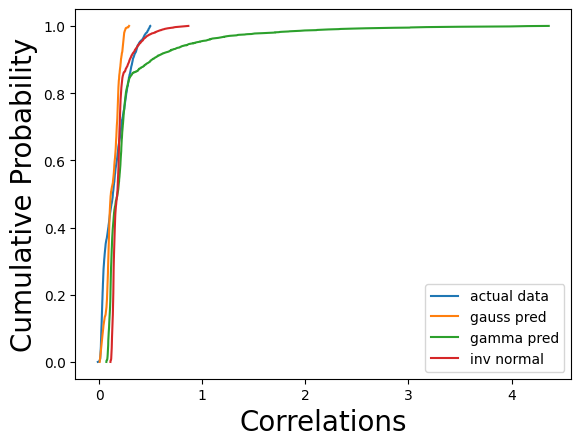

In [160]:
abib_cdf(abib_correlations, xlabel='Correlations', label='actual data')
abib_cdf(abib_corr_gauss_pred, xlabel='Correlations', label='gauss pred')
abib_cdf(abib_corr_gamma_pred, xlabel='Correlations', label='gamma pred')
abib_cdf(abib_corr_inv_pred, xlabel='Correlations', label='inv normal')
plt.legend()
# some gamma distribution might work 
# add histograms to this...

# infer postions from abib correlations on (x, y)

In [86]:
position_arr.reshape(-1, 2)

array([[1163, 1140],
       [1102, 1151],
       [1129, 1148],
       ...,
       [ 626,  626],
       [ 625,  622],
       [ 624,  623]], dtype=uint16)

In [103]:
abib_correlations.shape

(2000,)

* model the x

In [119]:
x_gamma = sm.GLM(x, abib_correlations, family=sm.families.Gamma())
x_possion = sm.GLM(x, abib_correlations, family=sm.families.Poisson())
x_normal = sm.GLM(x, abib_correlations, family=sm.families.Gaussian())

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


* model the y

In [120]:
y_gamma = sm.GLM(y, abib_correlations, family=sm.families.Gamma())
y_possion= sm.GLM(y, abib_correlations, family=sm.families.Poisson())
y_normal= sm.GLM(y, abib_correlations, family=sm.families.Gaussian())

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [122]:
x_gamma_pred = x_gamma.fit().predict().astype('int')
x_normal_pred = x_normal.fit().predict().astype('int')
x_possion_pred = x_possion.fit().predict().astype('int')

In [123]:
y_gamma_pred = y_gamma.fit().predict().astype('int')
y_possion_pred = y_possion.fit().predict().astype('int')
y_normal_pred = y_normal.fit().predict().astype('int')

Text(0.5, 0.98, 'Overlay of model predictions with actual data')

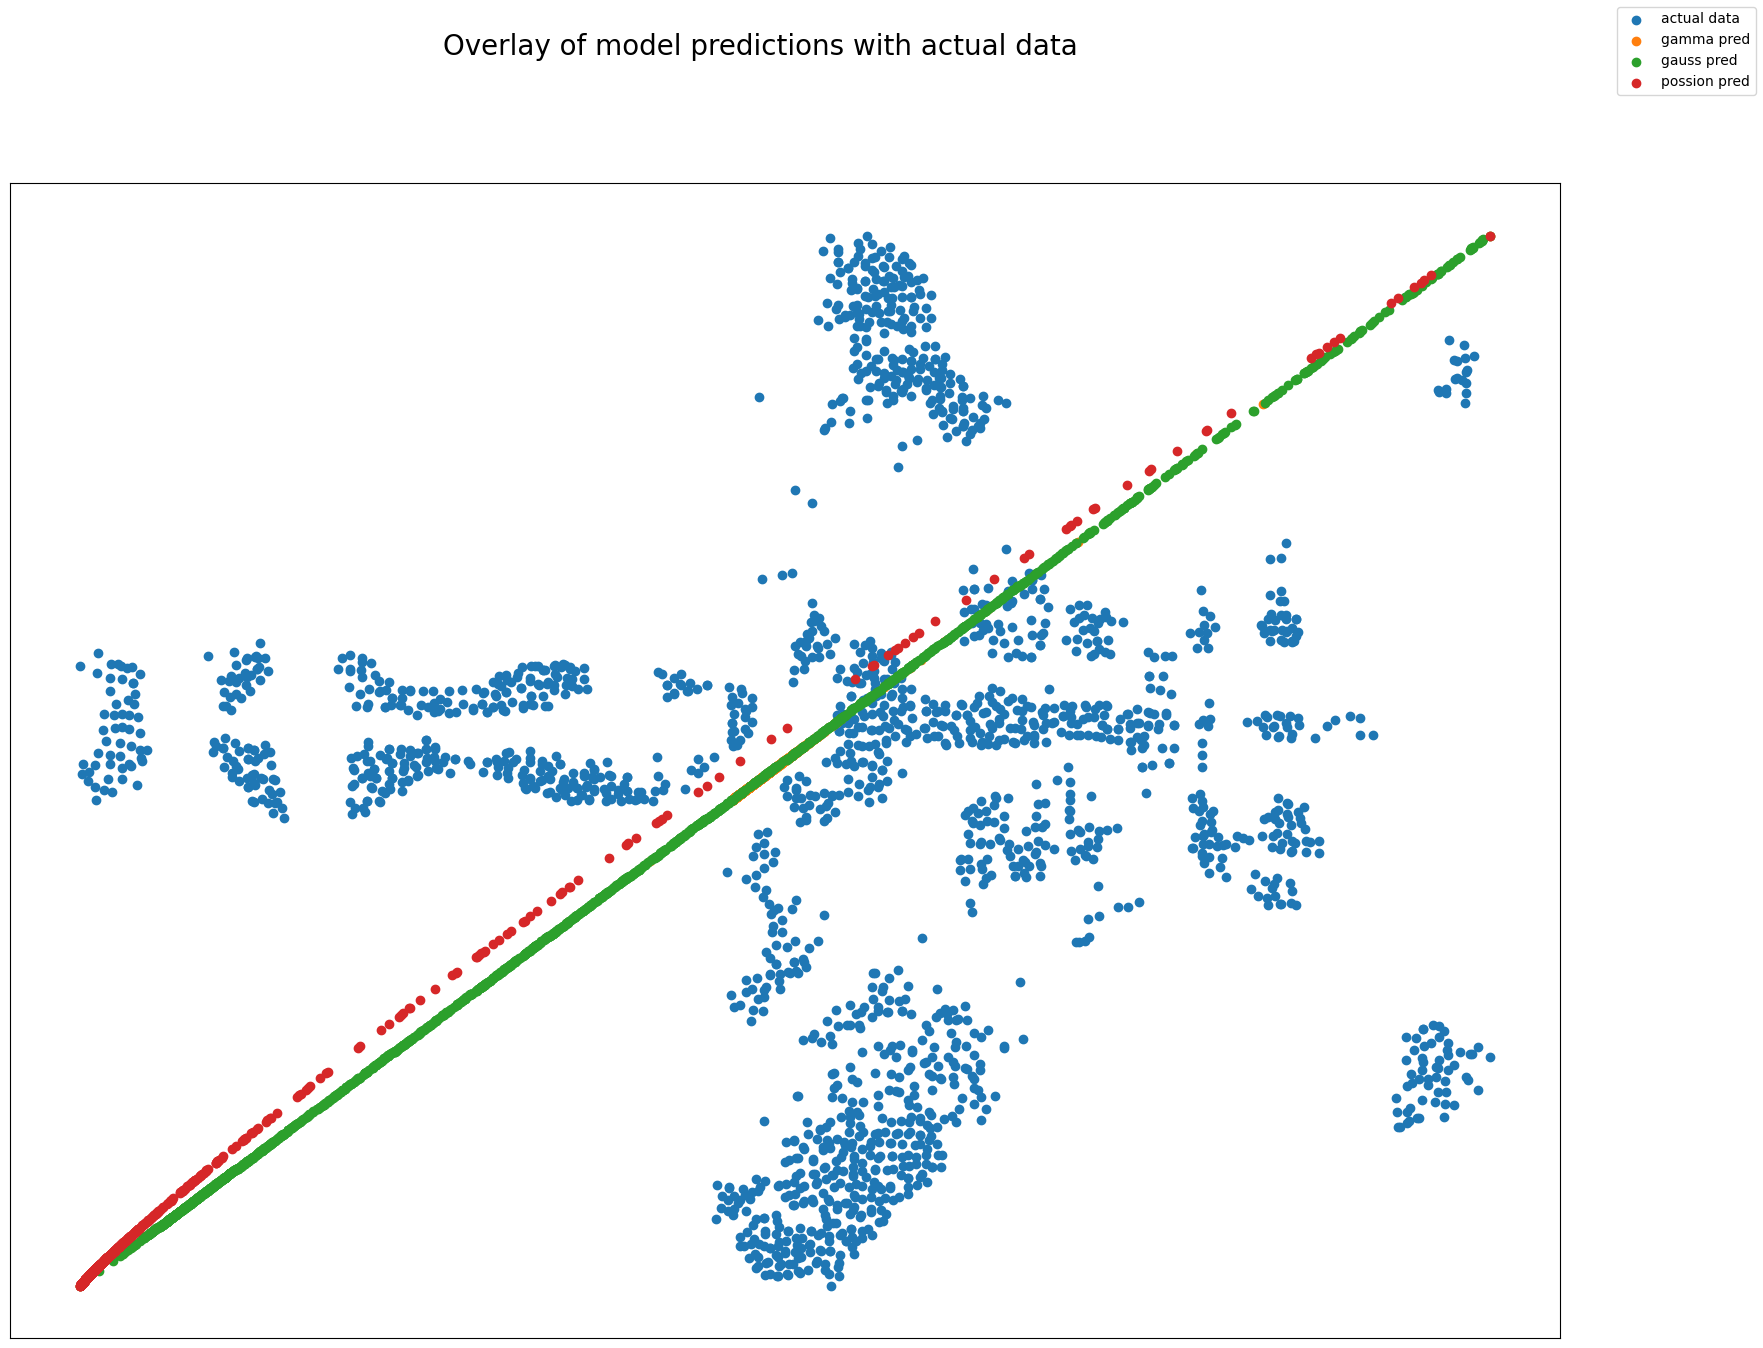

In [149]:
fig0 = plt.figure(figsize=(20, 15))
ax0 = fig0.add_subplot(111, label='actual data')
ax1 = fig0.add_subplot(111, label='gamma', frameon=False)
ax2 = fig0.add_subplot(111, label='normal', frameon=False)
ax3 = fig0.add_subplot(111, label='poisson', frameon=False)

ax0.scatter(x, y, label='actual data', color='C0')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.scatter(x_gamma_pred, y_gamma_pred, label='gamma pred', color='C1')
ax1.set_xticks([])
ax1.set_yticks([])


ax2.scatter(x_normal_pred, y_normal_pred, label='gauss pred', color='C2')
ax2.set_xticks([])
ax2.set_yticks([])


ax3.scatter(x_possion_pred, y_possion_pred, label='possion pred', color='C3')
ax3.set_xticks([])
ax3.set_yticks([])

fig0.legend()
fig0.suptitle('Overlay of model predictions with actual data', fontsize=20)

* need to get summaries of these.

In [161]:
x_gamma_res = x_gamma.fit().summary()
x_normal_res = x_normal.fit().summary()
x_possion_res = x_possion.fit().summary()

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1891: RuntimeWarning: overflow encountered in exp
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


In [162]:
y_gamma_res = y_gamma.fit().summary()
y_possion_res = y_possion.fit().summary()
y_normal_res = y_normal.fit().summary()

/Users/duuta/.pyenv/versions/3.9.16/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1891: RuntimeWarning: overflow encountered in exp
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


In [163]:
x_gamma_res

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1999
Model Family:                   Gamma   Df Model:                            0
Link Function:           InversePower   Scale:                          1.0557
Method:                          IRLS   Log-Likelihood:                -16947.
Date:                Mon, 04 Mar 2024   Deviance:                       2184.1
Time:                        17:40:47   Pearson chi2:                 2.11e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             -1.471
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0061      0.000     43.526      0.000       0.006       0.006
==============================================================================
"""

In [164]:
x_normal_res

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1999
Model Family:                Gaussian   Df Model:                            0
Link Function:               Identity   Scale:                      6.0587e+05
Method:                          IRLS   Log-Likelihood:                -16152.
Date:                Mon, 04 Mar 2024   Deviance:                   1.2111e+09
Time:                        17:40:47   Pearson chi2:                 1.21e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             -1.235
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4252.4672     88.464     48.070      0.000    4079.082    4425.853
==============================================================================
"""

In [165]:
x_possion_res

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1999
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.6965e+06
Date:                Mon, 04 Mar 2024   Deviance:                   1.5376e+07
Time:                        17:40:47   Pearson chi2:                 6.77e+08
No. Iterations:                    10   Pseudo R-squ. (CS):               -inf
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            19.0297      0.003   7249.340      0.000      19.025      19.035
==============================================================================
"""

* add link function

# color rois via with predicted abib_correlations

In [ ]:
ax1 = plt.subplot(220)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.scatter(x, y, marker='.', c=abib_correlations)

ax2 = plt.subplot(221)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.scatter(x, y, marker='.',)
ax2.set_title('Zoomed out')

ax3 = plt.subplot(222)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.scatter(t1, f(t1))
ax3.set_title('Zoomed in')
